In [109]:
%pip install pykan
%pip install torchvision

In this example, we will use KAN for unsupervised learning: we treat all variables on the equal footing (as input variables). Below we contruct a synthetic dataset where we have six variables

- $x_1,x_2,x_3$ are dependent such that $x_3= e^{\sin(\pi x_1) + x_2^2}$
- $x_4, x_5$are dependent such that $x_5 =x_4^3$
- $x_6$ indipendent

The idea is that we treat the problem as a classification problem.

The dataset that satisfies these interdependent relations are ‘positive’ samples, while corrupted samples (by random permutation of features across samples) are ‘negative’ samples.

We want to train a KAN to output 1 when it is a positive sample, and output 0 when it is a negative sample. We set the last layer activation to be Gaussian, so positive samples will have zero activation in the second to last layer, while negtive samples will have non-zero activation in the second to last layer.

We can then define the relation implicitly as $g=0$ where $g$ is the activation in the second to last layer

In [110]:
from kan import KAN
import torch
import copy

In [111]:
def create_dataset(train_num=500, test_num=500):

    def generate_contrastive(x):
        # positive samples
        batch = x.shape[0]
        x[:,2] = torch.exp(torch.sin(torch.pi*x[:,0])+x[:,1]**2)
        x[:,3] = x[:,4]**3

        # negative samples
        def corrupt(tensor):
            y = copy.deepcopy(tensor)
            for i in range(y.shape[1]):
                y[:,i] = y[:,i][torch.randperm(y.shape[0])]
            return y

        x_cor = corrupt(x)
        x = torch.cat([x, x_cor], dim=0)
        y = torch.cat([torch.ones(batch,), torch.zeros(batch,)], dim=0)[:,None]
        return x, y

    x = torch.rand(train_num, 6) * 2 - 1
    x_train, y_train = generate_contrastive(x)

    x = torch.rand(test_num, 6) * 2 - 1
    x_test, y_test = generate_contrastive(x)

    dataset = {}
    dataset['train_input'] = x_train.to(device)
    dataset['test_input'] = x_test.to(device)
    dataset['train_label'] = y_train.to(device)
    dataset['test_label'] = y_test.to(device)
    return dataset

In [112]:
device = 'cpu'
seed = 1

model = KAN(width=[6,1,1], grid=3, k=3, seed=seed, device=device)
dataset = create_dataset()

checkpoint directory created: ./model
saving model version 0.0


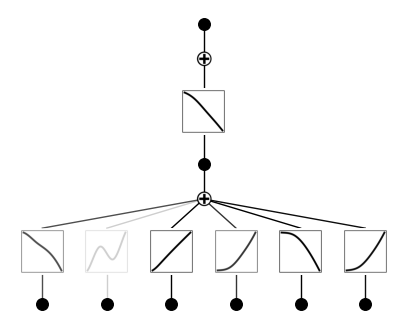

In [113]:
model(dataset['train_input'])
model.plot(beta=10)

In [114]:
# set the (1,0,0) activation to be gausssian
model.fix_symbolic(1,0,0,'gaussian',fit_params_bool=False)

saving model version 0.1


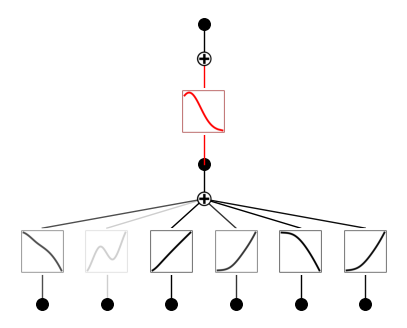

In [115]:
model(dataset['train_input'])
model.plot(beta=10)

In [116]:
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.002, lamb_entropy=10.0, lamb_coef=1.0);

| train_loss: 5.00e-01 | test_loss: 5.00e-01 | reg: 4.53e-01 | : 100%|█| 50/50 [00:19<00:00,  2.54it

saving model version 0.2


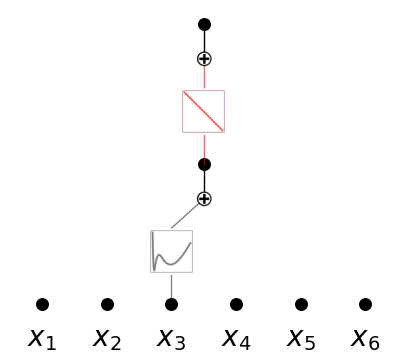

In [118]:
model.plot(in_vars=[r'$x_{}$'.format(i) for i in range(1,7)])

This gives the independence of $x_3$